In [2]:
import pandas as pd
import torch 
from torch import nn,utils,optim
from torchvision import transforms,models
from torch.nn import LayerNorm
import torch.nn.functional as F
import pickle
import json

In [3]:
#read the prompts file
df=pd.read_csv('diffusion_prompts.csv')
df.head()
#but we no longer use this dataset

,Unnamed: 0,id,prompt,url,width,height,source_site
0,0,00000d0e-45cb-47b6-9f72-6a481e940d78,"man waking up, dark and still room, cinematic ...",https://krea-prod-v1-generations.s3.us-east-1....,512,512,stablediffusionweb.com
1,1,00001a8f-993f-4d69-8fd2-f7d69dc1e8ef,Yate con familia feliz navegando por el mar ca...,https://image.lexica.art/full_jpg/00001a8f-993...,640,640,lexica.art
2,2,00002cfc-8170-4a93-a1f8-aa5681cb5f71,"Many friendly alien race individuals. fantasy,...",https://image.lexica.art/full_jpg/00002cfc-817...,512,768,lexica.art
3,3,00004467-fdef-41bc-bc73-20c68444a024,"theo james as cyclops, cyberpunk futuristic ne...",https://image.lexica.art/full_jpg/00004467-fde...,512,768,lexica.art
4,4,000044ca-a4d7-46a2-81da-7ef3bf4cbeeb,Portrait of a beautiful woman with long hair o...,https://image.lexica.art/full_jpg/000044ca-a4d...,512,768,lexica.art


In [4]:
#transfer the images in the new huggingface dataset to trainable tensor
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

folder_path=os.path.abspath('images2')
print(folder_path)

#define the transform of image
#using this transfrom method we convert all the images to grey images
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop((224,224)),
    transforms.Grayscale(num_output_channels=3),
    #transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4,hue=0.1),
    #transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

tensor_images_lst=[]

#access the derictory of all images
image_paths=[os.path.join(folder_path,f) for f in os.listdir(folder_path) if f.endswith('.png')]
print(len(image_paths))
for image_path in image_paths:
    print(len(tensor_images_lst))
    img=Image.open(image_path)
    tensor=transform(img)
    print(tensor.shape)
    tensor_images_lst.append(tensor)

print('the number of images is',len(tensor_images_lst))
print(tensor_images_lst[0].shape)




/Users/chijiean/Desktop/ML final project/ML final proproject code/images2
800
0
torch.Size([3, 224, 224])
1
torch.Size([3, 224, 224])
2
torch.Size([3, 224, 224])
3
torch.Size([3, 224, 224])
4
torch.Size([3, 224, 224])
5
torch.Size([3, 224, 224])
6
torch.Size([3, 224, 224])
7
torch.Size([3, 224, 224])
8
torch.Size([3, 224, 224])
9
torch.Size([3, 224, 224])
10
torch.Size([3, 224, 224])
11
torch.Size([3, 224, 224])
12
torch.Size([3, 224, 224])
13
torch.Size([3, 224, 224])
14
torch.Size([3, 224, 224])
15
torch.Size([3, 224, 224])
16
torch.Size([3, 224, 224])
17
torch.Size([3, 224, 224])
18
torch.Size([3, 224, 224])
19
torch.Size([3, 224, 224])
20
torch.Size([3, 224, 224])
21
torch.Size([3, 224, 224])
22
torch.Size([3, 224, 224])
23
torch.Size([3, 224, 224])
24
torch.Size([3, 224, 224])
25
torch.Size([3, 224, 224])
26
torch.Size([3, 224, 224])
27
torch.Size([3, 224, 224])
28
torch.Size([3, 224, 224])
29
torch.Size([3, 224, 224])
30
torch.Size([3, 224, 224])
31
torch.Size([3, 224, 224])
32
t

In [5]:
#we further consider how to preserve the color of the image and convert the gery images to colored RGB images
def transform_image(image_path):
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
    ])
    image=Image.open(image_path)
    #print(type(image))
    if image.mode=='L':
        image=transforms.Grayscale(num_output_channels=3)(image)
    else:
        image=image.convert('RGB')
    image=transform(image)
    return image
#get the list of three channel tensor representation of the images
#shape of colored_lst:[800,3,244,244]([num_images,num_channels,width,height])
#this tensor can be directly used as the input of CNN network
colored_lst=[]
for image_path in image_paths:
    colored_lst.append(transform_image(image_path))
    print(len(colored_lst))
#print(colored_lst[0])
X_train=torch.stack(colored_lst)
print(X_train.shape)
print(X_train[0])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [65]:
#try to build a iterator to load this images in the dataset
from torch.utils.data import Dataset,DataLoader
folder_path=os.path.abspath('images2')
print(folder_path)
class ImageDataset(Dataset):
    def __init__(self,folder_path):
        self.folder_path=folder_path
        self.image_paths=[os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        self.transform=transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.CenterCrop((224,224)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                            ])
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self,idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        img_tensor = self.transform(img)
        return img_tensor

batch_size=10

dataset=ImageDataset(folder_path)
dataloader=DataLoader(dataset,batch_size,shuffle=True)

/Users/chijiean/Desktop/ML final project/ML final proproject code/images2


In [6]:
#use dataloader to load data batch by batch
lst_tensor=[]
for batch_idx,batch_images in enumerate(dataloader):
    #print(len(batch_images))
    for images in batch_images:
        lst_tensor.append(images)
    #print(len(lst_tensor))
print(len(lst_tensor))
print(lst_tensor[0])

NameError: name 'dataloader' is not defined

In [6]:
#import other modules to build simCLR model
import cv2
import random
from torchvision.transforms import functional as F
from torch import nn
import torch.optim as optim

In [7]:
#then we build the simCLR model to do the self_supervised learning of the input images
#goal: automatically encode the images into 1*n dimensional vectors (1*128)

#first step: data augumentation:
#approach 1: Gaussian blur
class GaussianBlur(object):
    def __init__(self,kernel_size=3,p=0.5,min=0.1,max=2.0):
        self.min=min
        self.max=max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size=kernel_size
        self.p = p
    
    def __call__(self,sample):
        #sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()
        print(type(sample))
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        sample = transform(sample)
        #print(type(sample))
        #print(sample.shape)
        array=sample.numpy()
        if prob < self.p:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            array = cv2.GaussianBlur(array, (self.kernel_size, self.kernel_size), sigma)
        tensor=torch.tensor(array)
        print(tensor.shape)
        return tensor

#approach 2: Random color distortion
class ColorDistortion(object):
    def __init__(self,s=1.0):
        self.s=s
    
    def __call__(self,sample):
        color_jitter=transforms.ColorJitter(0.8*self.s,0.8*self.s,0.8*self.s,0.2*self.s)
        rnd_color_jitter=transforms.RandomApply([color_jitter],p=0.8)
        rnd_gray=transforms.RandomGrayscale(p=0.2)
        color_distort=transforms.Compose([
            rnd_color_jitter,rnd_gray
        ])
        if sample.mode=='L':
            sample=transforms.Grayscale(num_output_channels=3)(sample)
        else:
            sample=sample.convert('RGB')
        #print(type(sample))
        #returns a combination of distorting color
        return color_distort(sample)
    
#implementing this class: img=Image.open(image path)  img=ColorDistortion(img)
#then we can get the image after color distortion

#approach 3: random resized crop
class RandomResizedCrop(object):
    def __init__(self,size,scale=(0.08,1.0),ratio=(3.0/4.0,4.0/3.0)):
        self.size=size
        self.scale=scale
        self.ratio=ratio

    def __call__(self,img):
        w,h=img.size

        crop_size=int(random.uniform(self.scale[0],self.scale[1])*min(w,h))
        aspect_ratio=random.uniform(self.ratio[0],self.ratio[1])
        w_crop=int(round(crop_size*aspect_ratio))
        h_crop=int(round(crop_size/aspect_ratio))

        i=random.randint(0,h-h_crop)
        j=random.randint(0,w-w_crop)

        img=F.resized_crop(img,i,j,h_crop,w_crop,self.size)





In [8]:
#define the projection head
#this neural network projects the output of the encoder to a 128 dimensional vector for the calculation of nt_xent_loss
#but this projection network has so many bugs
class Projection(nn.Module):
    def __init__(self,input_dim=2048,hidden_dim=500,output_dim=128):
        super(Projection,self).__init__()
        self.output_dim=output_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.pool=nn.AdaptiveAvgPool2d((1, 1))
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.norm=nn.BatchNorm1d(self.hidden_dim)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(self.hidden_dim, self.output_dim, bias=False)
        '''self.model = nn.Sequential(
            nn.AdaptiveAvgPonn.BatchNorm1d(self.hidden_dim)ol2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.input_dim, self.hidden_dim, bias=True),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim, bias=False))'''
    def forward(self, x):
        '''x = self.model(x)'''
        #print(x.shape)
        x=self.pool(x)
        #print(x.shape)
        x=self.flatten(x)
        #print(x.shape)
        x=self.fc1(x)
        #print(x.shape)
        x=self.norm(x)
        #print(x.shape)
        x=self.relu(x)
        #print(x.shape)
        x=self.fc2(x)
        #print(x.shape)
        return F.normalize(x, dim=1)

In [9]:
# we change to use this projection network
class Projection2(nn.Module):
    def __init__(self,input_dim=2048,output_dim=128):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(self.input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.output_dim)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [10]:
#define teh xt_xent_loss
def nt_xent_loss(out_1, out_2, temperature):
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)

    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)

    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)

    # Positive similarity
    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    loss = -torch.log(pos / neg).mean()
    return loss

In [ ]:
#example of how to train use the nt_ent_loss as the loss function
#model if to be defined
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# 假设输入是 x1 和 x2
out_1, out_2 = model(x1), model(x2)
loss = nt_xent_loss(out_1, out_2, temperature)

optimizer.zero_grad()
loss.backward()
optimizer.step()


In [11]:
#we use the ResNet18 convolutional neural network as the encoder network
class ResNet18(nn.Module):
    def __init__(self,output_dim=2048):
        super(ResNet18,self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 224, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(224),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, output_dim) 

    # the input should be the size of (batch_size*3*256*256)
    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)

        x=self.layer1(x)+x
        print(x.shape)
        print(self.layer2(x).shape)
        x=self.layer2(x)+x
        x=self.layer3(x)+x
        x=self.layer4(x)+x

        x=self.avgpool(x)
        x=x.view(x.size(0),-1)
        x=self.fc(x)

        return x

In [12]:
import torch.nn.functional as F
#define another ResNet18 neural network
class ResNet18_2(nn.Module):
    def __init__(self,output_dim=2048):
        super(ResNet18_2,self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.conv1_bn = nn.BatchNorm2d(5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, output_dim)
        self.fc3_bn = nn.BatchNorm1d(output_dim)

        #use Xavier initialization to avoid gradient vanish
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        residue=x
        
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        #print(x.shape)
        x = x.view(-1, 16 * 53 * 53)
        #print(x.shape)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        #print(x.shape)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        #print(x.shape)
        x = self.fc3_bn(self.fc3(x))
        #print('ResNet18 finished')
        #x+=residue.view(-1,16*53*53)
        #x=F.relu(x)
        return x


In [13]:
#join the ResNet18 encoder and projecter together as a new model
class ConcatenatedModel(nn.Module):
    def __init__(self,net1,net2):
        super(ConcatenatedModel,self).__init__()
        self.net1=net1
        self.net2=net2

    def forward(self,x):
        #in this case, the ResNet18 neural network takes the input diim(batch_size,3,256,256) to 2048
        x=self.net1(x)
        #the projector nn takes input dim 2048 to 128
        x=self.net2(x)

        return x
        

In [14]:
#init the network
model=ConcatenatedModel(ResNet18_2(),Projection2())
print('model structure',model)
optimizer=optim.Adam(model.parameters(),lr=2e-3)

criterion=nn.MSELoss()
n_train_data=len(colored_lst)
n_iterations=5
batch_size=100
n_batch=int(np.ceil(n_train_data/batch_size))


model structure ConcatenatedModel(
  (net1): ResNet18_2(
    (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
    (conv1_bn): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=44944, out_features=120, bias=True)
    (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=84, out_features=2048, bias=True)
    (fc3_bn): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (net2): Projection2(
    (fc1): Linear(in_features=2048, o

In [15]:
#data augmentation
def transform_to_tensor(image):
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
    ])
    img_tensor=transform(image)
    return img_tensor

img1_lst=[]
img2_lst=[]
img3_lst=[]

for image_path in image_paths:
    img=Image.open(image_path)
    #define the three ways to augument the image
    ColorDis=ColorDistortion()
    img1=ColorDis(img)
    #print(type(img1))
    img1_tensor=transform_to_tensor(img1)
    img1_lst.append(img1_tensor)
    
    #img2=RandomResizedCrop(img)
    #print(type(img2))
    #img2_tensor=transform_to_tensor(img2)
    #img2_lst.append(img2_tensor)
    GaussBlur=GaussianBlur()
    #print(type(img3))
    print(type(img))
    img3=GaussBlur(img)
    #print(type(img3))
    #img3_tensor=torch.tensor(img3)
    img3_lst.append(tensor)
    print(len(img1_lst))
img1_lst_tensor=torch.stack(img1_lst)
#print(img3_lst[0].shape)
img3_lst_tensor=torch.stack(img3_lst)
#img2_tensor=torch.stack(img2_lst)
#img3_tensor=torch.stack(img3_lst)

print(img1_lst_tensor.shape)
print(img3_lst_tensor.shape)










<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([3, 224, 224])
1
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([3, 224, 224])
2
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([3, 224, 224])
3
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([3, 224, 224])
4
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([3, 224, 224])
5
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([3, 224, 224])
6
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([3, 224, 224])
7
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([3, 224, 224])
8
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.

In [15]:
print(img1_lst[0].shape)
print(img1_lst[1].shape)
print(img3_lst[0].shape)
print(img3_lst[2].shape)
print(img3_lst[100].shape)
print(img3_lst[500].shape)


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [16]:
print(img1_lst[0])

tensor([[[0.1373, 0.1294, 0.0784,  ..., 0.0706, 0.0627, 0.0471],
         [0.1216, 0.1333, 0.1059,  ..., 0.1020, 0.0941, 0.0510],
         [0.1333, 0.1373, 0.1176,  ..., 0.1020, 0.1020, 0.0902],
         ...,
         [0.0431, 0.0431, 0.0392,  ..., 0.0392, 0.0353, 0.0314],
         [0.0471, 0.0510, 0.0549,  ..., 0.0627, 0.0431, 0.0353],
         [0.0431, 0.0510, 0.0588,  ..., 0.1137, 0.0863, 0.0588]],

        [[0.1020, 0.0980, 0.0627,  ..., 0.0392, 0.0353, 0.0314],
         [0.0902, 0.1020, 0.0941,  ..., 0.0471, 0.0431, 0.0314],
         [0.1020, 0.1059, 0.1098,  ..., 0.0471, 0.0471, 0.0471],
         ...,
         [0.0471, 0.0471, 0.0471,  ..., 0.0588, 0.0549, 0.0510],
         [0.0510, 0.0588, 0.0588,  ..., 0.0784, 0.0588, 0.0510],
         [0.0510, 0.0549, 0.0627,  ..., 0.1294, 0.0980, 0.0745]],

        [[0.0980, 0.0941, 0.0627,  ..., 0.0353, 0.0353, 0.0275],
         [0.0863, 0.1020, 0.0941,  ..., 0.0431, 0.0392, 0.0275],
         [0.1020, 0.1020, 0.1098,  ..., 0.0431, 0.0392, 0.

In [93]:
print(img3_lst[0])

tensor([[[-0.9451, -0.9373, -0.9294,  ..., -0.9608, -0.9686, -0.9686],
         [-0.9373, -0.9216, -0.9137,  ..., -0.9608, -0.9686, -0.9686],
         [-0.9294, -0.9137, -0.8980,  ..., -0.9608, -0.9608, -0.9686],
         ...,
         [ 0.0275,  0.0824,  0.0980,  ...,  0.1216, -0.0510, -0.2235],
         [ 0.0275, -0.0039,  0.0980,  ..., -0.0667, -0.1843, -0.3569],
         [-0.0353,  0.0431,  0.1765,  ..., -0.1294, -0.3020, -0.4745]],

        [[-0.9451, -0.9373, -0.9294,  ..., -0.9608, -0.9686, -0.9686],
         [-0.9373, -0.9216, -0.9137,  ..., -0.9608, -0.9686, -0.9686],
         [-0.9294, -0.9137, -0.8980,  ..., -0.9608, -0.9608, -0.9686],
         ...,
         [ 0.0275,  0.0824,  0.0980,  ...,  0.1216, -0.0510, -0.2235],
         [ 0.0275, -0.0039,  0.0980,  ..., -0.0667, -0.1843, -0.3569],
         [-0.0353,  0.0431,  0.1765,  ..., -0.1294, -0.3020, -0.4745]],

        [[-0.9451, -0.9373, -0.9294,  ..., -0.9608, -0.9686, -0.9686],
         [-0.9373, -0.9216, -0.9137,  ..., -0

In [16]:
#split train and validate 
train_tensor1,val_tensor1=torch.split(img1_lst_tensor, [700, 100], dim=0)
train_tensor2,val_tensor2=torch.split(img3_lst_tensor, [700, 100], dim=0)

In [17]:
#then we feed image1_lst_tensor and image3_lst_tensor respectively to the encoder and projector
def train(n_iterations,n_batch,batch_size,train_tensor1,train_tensor2,val_tensor1,val_tensor2,criterion):
    train_loss_list=np.zeros(n_iterations)
    val_loss_list = np.zeros(n_iterations)
    #for some loss functions, the change in loss is too rapid over each iterations
    #so we also collect the train and validation loss over each batch
    batch_loss_lst=[]
    batch_eval_lst=[]
    for i in range(n_iterations):
        loss_lst=[]
        for j in range(n_batch):
            print(j)
            batch_start_index=j*batch_size
            batch_tensor1=train_tensor1[batch_start_index:batch_start_index+batch_size]
            batch_tensor2=train_tensor2[batch_start_index:batch_start_index+batch_size]
            output1=model(batch_tensor1)
            output2=model(batch_tensor2)
            #batch_loss=nt_xent_loss(output1,output2,temperature=10)
            batch_loss=criterion(output1,output2)

            #also collect the loss of each batch in another list
            batch_loss_lst.append(batch_loss)

            #see if the gradient vanishieszz
            count=0
            for name,param in model.named_parameters():
                #print(name,param.grad)
                count+=1
                if count==10:
                    break
            
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            loss_lst.append(batch_loss)

            #also do evaluation for each batch
            val_output1=model(val_tensor1)
            val_output2=model(val_tensor2)
            batch_eval_loss=criterion(val_output1,val_output2)
            batch_eval_lst.append(batch_eval_loss)
            print('the batch train loss is',batch_loss,'the batch evaluation lst is',batch_eval_loss)
    
        train_loss_list[i]=(sum(loss_lst)/len(loss_lst))
        output_val_1=model(val_tensor1)
        output_val_2=model(val_tensor2)
        #val_loss=nt_xent_loss(output_val_1,output_val_2,temperature=10)
        val_loss=criterion(output_val_1,output_val_2)
        val_loss_list[i]=val_loss
        print("Iter %d ,Train loss: %.3f, Val loss: %.3f," 
          %(i ,train_loss_list[i], val_loss))
    return train_loss_list,val_loss_list,batch_loss_lst,batch_eval_lst





In [26]:
#use the MSE loss to train
train_loss_MSE,val_loss_MSE,betch_train_loss_MSE,batch_eval_loss_MSE=train(1,14,50,train_tensor1,train_tensor2,val_tensor1,val_tensor2,nn.MSELoss())

0
the batch train loss is tensor(0.0094, grad_fn=<MseLossBackward0>) the batch evaluation lst is tensor(0.0084, grad_fn=<MseLossBackward0>)
1
the batch train loss is tensor(0.0155, grad_fn=<MseLossBackward0>) the batch evaluation lst is tensor(0.0097, grad_fn=<MseLossBackward0>)
2
the batch train loss is tensor(0.0080, grad_fn=<MseLossBackward0>) the batch evaluation lst is tensor(0.0024, grad_fn=<MseLossBackward0>)
3
the batch train loss is tensor(0.0024, grad_fn=<MseLossBackward0>) the batch evaluation lst is tensor(0.0004, grad_fn=<MseLossBackward0>)
4
the batch train loss is tensor(0.0006, grad_fn=<MseLossBackward0>) the batch evaluation lst is tensor(0.0001, grad_fn=<MseLossBackward0>)
5
the batch train loss is tensor(0.0001, grad_fn=<MseLossBackward0>) the batch evaluation lst is tensor(4.3867e-05, grad_fn=<MseLossBackward0>)
6
the batch train loss is tensor(4.1842e-05, grad_fn=<MseLossBackward0>) the batch evaluation lst is tensor(1.6070e-05, grad_fn=<MseLossBackward0>)
7
the ba

In [27]:

for i in range(len(betch_train_loss_MSE)):
    betch_train_loss_MSE[i]=betch_train_loss_MSE[i].item()
    batch_eval_loss_MSE[i]=batch_eval_loss_MSE[i].item()
print(betch_train_loss_MSE)
print(batch_eval_loss_MSE)


[0.009384233504533768, 0.015469137579202652, 0.008007431402802467, 0.0023778423201292753, 0.0006434679962694645, 0.0001306570047745481, 4.184225690551102e-05, 7.571563855890417e-07, 1.146413879382635e-07, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.008439205586910248, 0.0096596023067832, 0.0024407925084233284, 0.0003967344528064132, 0.00014048746379557997, 4.386650107335299e-05, 1.607012382009998e-05, 9.402898285770789e-06, 6.322102763078874e-06, 4.047341008117655e-06, 2.580446107458556e-06, 1.6255332866421668e-06, 9.951309039024636e-07, 6.149205660221924e-07]


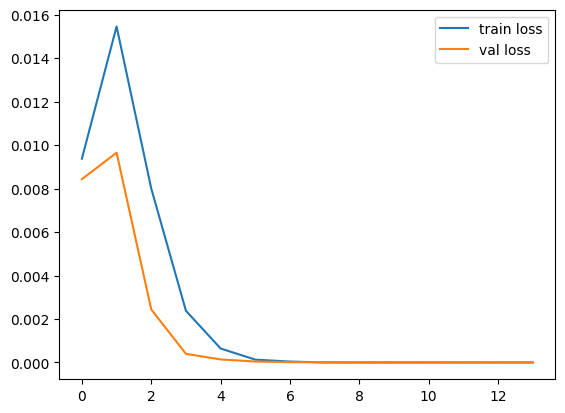

In [28]:
#plot the trianing losses vs validation loss
import matplotlib.pyplot as plt
x_axis=np.arange(14)
plt.plot(x_axis,betch_train_loss_MSE,label='train loss')
plt.plot(x_axis,batch_eval_loss_MSE,label='val loss')
plt.legend()
plt.show()


In [29]:
#get the data from the MSE trianed model
model.eval()
fully_embedded_image_tensor=model(X_train)
print(fully_embedded_image_tensor.shape)
print(fully_embedded_image_tensor[0])

torch.Size([800, 128])
tensor([ 0.0244, -0.0160,  0.0186,  0.0620,  0.0406, -0.0042, -0.0471, -0.0112,
        -0.0109,  0.0423,  0.0158, -0.0003, -0.0040,  0.0116, -0.0594,  0.0445,
        -0.0309,  0.0298,  0.0281,  0.0482,  0.0429, -0.0313, -0.0104, -0.0368,
        -0.0509, -0.0135,  0.0282,  0.0137, -0.0024,  0.0387,  0.0386,  0.0618,
         0.0616,  0.0040, -0.0515, -0.0117,  0.0041, -0.0199,  0.0546,  0.0366,
        -0.0060, -0.0406,  0.0086, -0.0291,  0.0061,  0.0270,  0.0475, -0.0461,
         0.0011,  0.0070, -0.0159, -0.0599,  0.0400,  0.0197, -0.0123, -0.0580,
         0.0569,  0.0498,  0.0505, -0.0190,  0.0327,  0.0116, -0.0527,  0.0444,
         0.0380,  0.0484,  0.0395, -0.0299,  0.0323, -0.0083,  0.0320,  0.0121,
        -0.0386,  0.0010, -0.0408, -0.0254, -0.0529, -0.0215, -0.0513,  0.0506,
         0.0118, -0.0600,  0.0617,  0.0034, -0.0220, -0.0321,  0.0058,  0.0283,
         0.0003, -0.0170,  0.0076,  0.0179, -0.0100, -0.0255,  0.0007,  0.0236,
         0.0211, 

In [18]:
#use the triplet loss
train_loss_Tri,val_loss_Tri,betch_train_loss_Tri,batch_eval_loss_Tri=train(1,14,50,train_tensor1,train_tensor2,val_tensor1,val_tensor2,nn.TripletMarginLoss(margin=1.0))

0


TypeError: forward() missing 1 required positional argument: 'negative'